<a href="https://colab.research.google.com/github/yasharth291/Hacktoberfest-python/blob/master/federated_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall --quiet --yes tensorflow-datasets tensorflow-metadata
!pip install --quiet --upgrade nest_asyncio
!pip install --quiet --upgrade tensorflow_federated_nightly
!pip install --quiet --upgrade tensorflow_privacy

     |████████████████████████████████| 821 kB 7.1 MB/s 
     |████████████████████████████████| 65.2 MB 107 kB/s 
     |████████████████████████████████| 53 kB 872 kB/s 
     |████████████████████████████████| 887 kB 11.1 MB/s 
     |████████████████████████████████| 4.2 MB 42.4 MB/s 
     |████████████████████████████████| 120 kB 79.8 MB/s 
     |████████████████████████████████| 126 kB 77.5 MB/s 
     |████████████████████████████████| 251 kB 65.2 MB/s 
     |████████████████████████████████| 45 kB 4.2 MB/s 
     |████████████████████████████████| 553.8 MB 7.5 kB/s 
     |████████████████████████████████| 238 kB 50.0 MB/s 
     |████████████████████████████████| 4.7 MB 49.9 MB/s 
     |████████████████████████████████| 52 kB 900 kB/s 
     |████████████████████████████████| 1.7 MB 64.5 MB/s 
     |████████████████████████████████| 553.8 MB 25 kB/s 
     |████████████████████████████████| 553.8 MB 20 kB/s 
     |████████████████████████████████| 553.2 MB 29 kB/s 
     |██████████████

In [11]:
import collections
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd
import sklearn
import tempfile
import tensorflow as tf
from collections import defaultdict 
from io import StringIO
from keras.utils import to_categorical
from matplotlib.pyplot import figure
from numpy import loadtxt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import requests
import tensorflow_federated as tff

nest_asyncio.apply()
tff.framework.set_default_context(tff.backends.native.create_thread_debugging_execution_context(clients_per_thread=50))
np.random.seed(10)
tf.random.set_seed(10)

f = tempfile.NamedTemporaryFile(mode="w")

def get_diabetes_dataset():
  # Download data from  and paste to return statement here.
  return requests.get('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv', allow_redirects=True).text


def get_diabetes_labels():
  return [
      "intercept", "Number of times pregnant", "Plasma glucose concentration",
      "Diastolic blood pressure", "Triceps skin fold thickness",
      "2-Hour serum insulin (mu U/ml)", "BMI", "Diabetes pedigree function",
      "Age (years)", "Diabetic?"
  ]

dataset = get_diabetes_dataset()
labels = get_diabetes_labels()

f.write(dataset)
dataset = loadtxt(f.name, delimiter=",", skiprows=1)
num_col = np.size(dataset, 1)
X = dataset[:, 0:num_col-1]
y = dataset[:, num_col-1]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

D = np.column_stack((X, y))
ds = pd.DataFrame(
    data=D,
    columns=labels[1:])

ds

,Number of times pregnant,Plasma glucose concentration,Diastolic blood pressure,Triceps skin fold thickness,2-Hour serum insulin (mu U/ml),BMI,Diabetes pedigree function,Age (years),Diabetic?
0,-0.843726,-1.122086,-0.160249,0.532023,-0.693559,-0.683729,-0.364265,-0.188940,0.0
1,1.234240,1.944476,-0.263578,-1.286882,-0.693559,-1.102301,0.604701,-0.103795,1.0
2,-0.843726,-0.996920,-0.160249,0.155698,0.122357,-0.493469,-0.919684,-1.040393,0.0
3,-1.140579,0.505069,-1.503534,0.908349,0.764674,1.409132,5.482732,-0.018650,1.0
4,0.343683,-0.152051,0.253070,-1.286882,-0.693559,-0.810569,-0.817052,-0.274086,0.0
...,...,...,...,...,...,...,...,...,...
762,1.827945,-0.621423,0.356400,1.723720,0.868833,0.115363,-0.907610,2.535709,0.0
763,-0.546874,0.035698,0.046411,0.406582,-0.693559,0.610039,-0.397469,-0.529522,0.0
764,0.343683,0.004406,0.149740,0.155698,0.278596,-0.734465,-0.684235,-0.274086,0.0
765,-0.843726,0.160863,-0.470238,-1.286882,-0.693559,-0.239789,-0.370302,1.173384,1.0


In [4]:
TRAIN_PROPORTION = 0.8
NUM_FEATURES = np.size(X, 1)
NUM_ROUNDS = 5
n_train = round(TRAIN_PROPORTION * np.size(X, 0))
NUM_CLIENTS = n_train
NUM_PARTICIPATING_PER_ROUND = round(NUM_CLIENTS/3)

data_train = X[:n_train]
labels_train =  y[:n_train]
data_test = X[n_train:]
labels_test =  y[n_train:]

In [5]:
sk_model = LogisticRegression(random_state=0, solver='liblinear').fit(data_train, labels_train)
proba = sk_model.predict_proba(data_test)
labels_proba = proba[:,1]
fpr_skl_liblinear, tpr_skl_liblinear, threshold_skl_liblinear = sklearn.metrics.roc_curve(labels_test, labels_proba)
roc_auc_skl_liblinear = sklearn.metrics.auc(fpr_skl_liblinear, tpr_skl_liblinear)
print(roc_auc_skl_liblinear)

sk_model = LogisticRegression(random_state=0, solver='sag').fit(data_train, labels_train)
proba = sk_model.predict_proba(data_test)
labels_proba = proba[:,1]
fpr_skl_sag, tpr_skl_sag, threshold_skl_sag = sklearn.metrics.roc_curve(labels_test, labels_proba)
roc_auc_skl_sag = sklearn.metrics.auc(fpr_skl_sag, tpr_skl_sag)
print(roc_auc_skl_sag)

sk_model = LogisticRegression(random_state=0, solver='lbfgs').fit(data_train, labels_train)
proba = sk_model.predict_proba(data_test)
labels_proba = proba[:,1]
fpr_skl, tpr_skl, threshold_skl = sklearn.metrics.roc_curve(labels_test, labels_proba)
roc_auc_skl = sklearn.metrics.auc(fpr_skl, tpr_skl)
print(roc_auc_skl)

0.845679012345679
0.845679012345679
0.845679012345679


In [6]:
dataset_train = tf.data.Dataset.from_tensor_slices((data_train, labels_train)).batch(n_train)
dataset_test = tf.data.Dataset.from_tensor_slices((data_test, labels_test)).batch(n_train)

def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Dense(
          1,
          activation='sigmoid',
          input_shape=(NUM_FEATURES,),
          kernel_regularizer=tf.keras.regularizers.l2(0.01),
      )
  ])

def create_keras_model_deeper():
  initializer = tf.keras.initializers.GlorotNormal(seed=10)
  m = tf.keras.models.Sequential()
  m.add(tf.keras.Input(shape=(NUM_FEATURES,)))
  m.add(tf.keras.layers.Dense(6, activation='sigmoid', kernel_initializer=initializer))
  m.add(tf.keras.layers.Dense(3, activation='sigmoid', kernel_initializer=initializer))
  m.add(tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=initializer, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.0001, l2=0.01)))
  return m
  

tf_model = create_keras_model()
tf_model.compile(
              optimizer=tf.keras.optimizers.Nadam(learning_rate=0.5),   
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[
                       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.AUC(name='auc'),
                       ]
              )
tf_model.fit(dataset_train, validation_data=dataset_test, epochs=NUM_ROUNDS, batch_size=NUM_PARTICIPATING_PER_ROUND, verbose=1, use_multiprocessing=True)

labels_proba = tf_model.predict(dataset_test)
fpr_tf, tpr_tf, threshold = sklearn.metrics.roc_curve(labels_test, labels_proba)
roc_auc_tf = sklearn.metrics.auc(fpr_tf, tpr_tf)

Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.8643 - accuracy: 0.4723 - auc: 0.4804 - val_loss: 0.6571 - val_accuracy: 0.7320 - val_auc: 0.7703
Epoch 2/5
1/1 [==============================] - 0s 26ms/step - loss: 0.7008 - accuracy: 0.6922 - auc: 0.7123 - val_loss: 0.5403 - val_accuracy: 0.7712 - val_auc: 0.7942
Epoch 3/5
1/1 [==============================] - 0s 27ms/step - loss: 0.5529 - accuracy: 0.7345 - auc: 0.7840 - val_loss: 0.4945 - val_accuracy: 0.7908 - val_auc: 0.8579
Epoch 4/5
1/1 [==============================] - 0s 31ms/step - loss: 0.5055 - accuracy: 0.7622 - auc: 0.8231 - val_loss: 0.5000 - val_accuracy: 0.7908 - val_auc: 0.8481
Epoch 5/5
1/1 [==============================] - 0s 61ms/step


In [7]:
def create_client_dataset(data, labels):
  client_ids = range(len(data))

  def create_dataset_fn(client_id):
    return tf.data.Dataset.from_tensor_slices((data[client_id:client_id+1,:], labels[client_id:client_id+1]))

  return tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
      client_ids=client_ids,
      serializable_dataset_fn=create_dataset_fn)
  
def preprocess(dataset):
  return dataset.repeat(1).batch(1)

def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

client_dataset_train = create_client_dataset(data_train, labels_train)
client_dataset_test = create_client_dataset(data_test, labels_test)

preprocessed_example_dataset = preprocess(client_dataset_train.create_tf_dataset_for_client(client_dataset_train.client_ids[0]))

def tff_model_fn():
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
               tf.keras.metrics.AUC(name='auc')])
# Create TFF interative process.
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn=tff_model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.5),
)

state = iterative_process.initialize()
tff_model = create_keras_model()
tff_auc = defaultdict(lambda:0)

# Test various sizes of subsets of eligible devices participating in each round.
for participation in list(range(1, NUM_CLIENTS, 100)) + [NUM_CLIENTS]:
  for round_num in range(NUM_ROUNDS):
    federated_train_data = make_federated_data(client_dataset_train, np.random.choice(range(NUM_CLIENTS), size=participation, replace=False))
    state, metrics = iterative_process.next(state, federated_train_data)
    print(participation, round_num, str(metrics))
    state.model.assign_weights_to(tff_model)
    labels_proba = tff_model.predict(dataset_test)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(labels_test, labels_proba)
    test_loss = tf.keras.losses.binary_crossentropy(labels_test, np.reshape(labels_proba, [-1]))
    print('validation auc={}, loss={}'.format(sklearn.metrics.auc(fpr, tpr), test_loss))
    tff_auc[100*participation/float(NUM_CLIENTS)] = max(tff_auc[100*participation/float(NUM_CLIENTS)], sklearn.metrics.auc(fpr, tpr))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


1 0 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 1.0), ('auc', 0.0), ('loss', 0.64111066), ('num_examples', 1), ('num_batches', 1)]))])
1/1 [==============================] - 0s 36ms/step
validation auc=0.5164609053497943, loss=0.9380820393562317
1 1 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 1.0), ('auc', 0.0), ('loss', 0.17429325), ('num_examples', 1), ('num_batches', 1)]))])
1/1 [==============================] - 0s 7ms/step
validation auc=0.4988776655443322, loss=1.009859323501587
1 2 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 1.0), ('auc', 0.0), ('loss', 0.07475614), ('num_examples', 1), ('num_batches', 1)]))])
1/1 [==============================] - 0s 6ms/step
validation auc=0.4947624392068837

In [8]:
state.model.assign_weights_to(tff_model)
labels_proba = tff_model.predict(dataset_test)
fpr_tff_sgd, tpr_tff_sgd, threshold_tff_sgd = sklearn.metrics.roc_curve(labels_test, labels_proba)
roc_auc_tff_sgd = sklearn.metrics.auc(fpr_tff_sgd, tpr_tff_sgd)

1/1 [==============================] - 0s 10ms/step


In [33]:
print(preprocessed_example_dataset.element_spec)

tff_dp_auc = defaultdict(lambda:0)

# Test various sizes of subsets of eligible devices participating in each round.
for participation in list(range(1, NUM_CLIENTS, 100)) + [NUM_CLIENTS]:
  # DP process depends on participation rate to select noise scale.
  dp_query = tff.aggregators.DifferentiallyPrivateFactory.gaussian_fixed(
      clip=0.1,
      noise_multiplier=29.3,
      clients_per_round=participation,
    )

  weights_type = tff.learning.framework.weights_type_from_model(tff_model_fn)
  

  # Create TFF interative process.
  iterative_process = tff.learning.build_federated_averaging_process(
      tff_model_fn,
      client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
      server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.5),
      use_experimental_simulation_loop = True,
      #aggregation_process=dp_aggregation_process,
  )

  state = iterative_process.initialize()

  for round_num in range(10):
    federated_train_data = make_federated_data(client_dataset_train, np.random.choice(range(NUM_CLIENTS), size=participation, replace=False))
    state, metrics = iterative_process.next(state, federated_train_data)
    print(participation, round_num, str(metrics))
    tff_dp_model = create_keras_model() # reassigning weights to the same model was causing a bug
    state.model.assign_weights_to(tff_dp_model)
    labels_proba = tff_dp_model.predict(dataset_test)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(labels_test, labels_proba)
    test_loss = tf.keras.losses.binary_crossentropy(labels_test, np.reshape(labels_proba, [-1]))
    print('validation auc={}, loss={}'.format(sklearn.metrics.auc(fpr, tpr), test_loss))
    tff_dp_auc[100*participation/float(NUM_CLIENTS)] = max(tff_dp_auc[100*participation/float(NUM_CLIENTS)], sklearn.metrics.auc(fpr, tpr))

(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))
1 0 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.0), ('auc', 0.0), ('loss', 1.4440876), ('num_examples', 1), ('num_batches', 1)]))])
1/1 [==============================] - 0s 45ms/step
validation auc=0.4017957351290684, loss=1.1368050575256348
1 1 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 1.0), ('auc', 0.0), ('loss', 0.10286351), ('num_examples', 1), ('num_batches', 1)]))])
1/1 [==============================] - 0s 46ms/step
validation auc=0.39450056116722787, loss=1.1794822216033936
1 2 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 1.0), ('auc', 0.0), ('loss', 0.047911417), ('num_examp

1 3 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 1.0), ('auc', 0.0), ('loss', 0.5750114), ('num_examples', 1), ('num_batches', 1)]))])
1/1 [==============================] - 0s 50ms/step
validation auc=0.4521137298915077, loss=1.0896865129470825


1 4 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.0), ('auc', 0.0), ('loss', 0.939745), ('num_examples', 1), ('num_batches', 1)]))])
1/1 [==============================] - 0s 46ms/step
validation auc=0.37972315750093527, loss=1.1104371547698975
1 5 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 1.0), ('auc', 0.0), ('loss', 0.36935502), ('num_examples', 1), ('num_batches', 1)]))])
1/1 [==============================] - 0s 44ms/step
validation auc=0.41339319117096895, loss=1.045742154121399
1 6 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 1.0), ('auc', 0.0), ('loss', 0.36058336), ('num_examples', 1), ('num_batches', 1)]))])
1/1 [==============================] - 0s 44ms/step
validation auc=0.48204264870931

In [34]:
state.model.assign_weights_to(tff_dp_model)
labels_proba = tff_dp_model.predict(dataset_test)
fpr_tff_dp_sgd, tpr_tff_dp_sgd, threshold_tff_dp_sgd = sklearn.metrics.roc_curve(labels_test, labels_proba)
roc_auc_tff_dp_sgd = sklearn.metrics.auc(fpr_tff_dp_sgd, tpr_tff_dp_sgd)

1/1 [==============================] - 0s 12ms/step


In [42]:
!pip install tensorflow_privacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
from absl import logging
import collections
from tensorflow_privacy.privacy.dp_query import gaussian_query

def make_optimizer_class(cls):
  """Constructs a DP optimizer class from an existing one."""
  parent_code = tf.compat.v1.train.Optimizer.compute_gradients.__code__
  child_code = cls.compute_gradients.__code__
  GATE_OP = tf.compat.v1.train.Optimizer.GATE_OP  # pylint: disable=invalid-name
  if child_code is not parent_code:
    logging.warning(
        'WARNING: Calling make_optimizer_class() on class %s that overrides '
        'method compute_gradients(). Check to ensure that '
        'make_optimizer_class() does not interfere with overridden version.',
        cls.__name__)

  class DPOptimizerClass(cls):
    """Differentially private subclass of given class cls."""

    _GlobalState = collections.namedtuple(
      '_GlobalState', ['l2_norm_clip', 'stddev'])
    
    def __init__(
        self,
        dp_sum_query,
        num_microbatches=None,
        unroll_microbatches=False,
        *args,  # pylint: disable=keyword-arg-before-vararg, g-doc-args
        **kwargs):
      """Initialize the DPOptimizerClass.

      Args:
        dp_sum_query: DPQuery object, specifying differential privacy
          mechanism to use.
        num_microbatches: How many microbatches into which the minibatch is
          split. If None, will default to the size of the minibatch, and
          per-example gradients will be computed.
        unroll_microbatches: If true, processes microbatches within a Python
          loop instead of a tf.while_loop. Can be used if using a tf.while_loop
          raises an exception.
      """
      super(DPOptimizerClass, self).__init__(*args, **kwargs)
      self._dp_sum_query = dp_sum_query
      self._num_microbatches = num_microbatches
      self._global_state = self._dp_sum_query.initial_global_state()
      self._unroll_microbatches = unroll_microbatches

    def compute_gradients(self,
                          loss,
                          var_list,
                          gate_gradients=GATE_OP,
                          aggregation_method=None,
                          colocate_gradients_with_ops=False,
                          grad_loss=None,
                          gradient_tape=None,
                          curr_noise_mult=0,
                          curr_norm_clip=1):

      self._dp_sum_query = gaussian_query.GaussianSumQuery(curr_norm_clip, 
                                                           curr_norm_clip*curr_noise_mult)
      self._global_state = self._dp_sum_query.make_global_state(curr_norm_clip, 
                                                                curr_norm_clip*curr_noise_mult)
      

      # TF is running in Eager mode, check we received a vanilla tape.
      if not gradient_tape:
        raise ValueError('When in Eager mode, a tape needs to be passed.')

      vector_loss = loss()
      if self._num_microbatches is None:
        self._num_microbatches = tf.shape(input=vector_loss)[0]
      sample_state = self._dp_sum_query.initial_sample_state(var_list)
      microbatches_losses = tf.reshape(vector_loss, [self._num_microbatches, -1])
      sample_params = (self._dp_sum_query.derive_sample_params(self._global_state))

      def process_microbatch(i, sample_state):
        """Process one microbatch (record) with privacy helper."""
        microbatch_loss = tf.reduce_mean(input_tensor=tf.gather(microbatches_losses, [i]))
        grads = gradient_tape.gradient(microbatch_loss, var_list)
        sample_state = self._dp_sum_query.accumulate_record(sample_params, sample_state, grads)
        return sample_state
    
      for idx in range(self._num_microbatches):
        sample_state = process_microbatch(idx, sample_state)

      if curr_noise_mult > 0:
        grad_sums, self._global_state = (self._dp_sum_query.get_noised_result(sample_state, self._global_state))
      else:
        grad_sums = sample_state

      def normalize(v):
        return v / tf.cast(self._num_microbatches, tf.float32)

      final_grads = tf.nest.map_structure(normalize, grad_sums)
      grads_and_vars = final_grads
    
      return grads_and_vars

  return DPOptimizerClass


def make_gaussian_optimizer_class(cls):
  """Constructs a DP optimizer with Gaussian averaging of updates."""

  class DPGaussianOptimizerClass(make_optimizer_class(cls)):
    """DP subclass of given class cls using Gaussian averaging."""

    def __init__(
        self,
        l2_norm_clip,
        noise_multiplier,
        num_microbatches=None,
        ledger=None,
        unroll_microbatches=False,
        *args,  # pylint: disable=keyword-arg-before-vararg
        **kwargs):
      dp_sum_query = gaussian_query.GaussianSumQuery(
          l2_norm_clip, l2_norm_clip * noise_multiplier)

      if ledger:
        dp_sum_query = PrivacyLedger.QueryWithLedger(dp_sum_query,
                                                      ledger=ledger)

      super(DPGaussianOptimizerClass, self).__init__(
          dp_sum_query,
          num_microbatches,
          unroll_microbatches,
          *args,
          **kwargs)

    @property
    def ledger(self):
      return self._dp_sum_query.ledger

  return DPGaussianOptimizerClass

In [54]:
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPAdamGaussianOptimizer

l2_norm_clip = 0.1
noise_multiplier = 59.3
num_microbatches = 1
learning_rate = 0.5

GradientDescentOptimizer = tf.compat.v1.train.GradientDescentOptimizer
DPGradientDescentGaussianOptimizer_NEW = make_gaussian_optimizer_class(GradientDescentOptimizer)

dp_optimizer = DPGradientDescentGaussianOptimizer_NEW(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

dp_loss = tf.keras.losses.BinaryCrossentropy()

tf_dp_model = create_keras_model()
tf_dp_model.compile(
              optimizer=dp_optimizer,   
              loss=dp_loss,
              metrics=[
                       tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                       tf.keras.metrics.AUC(name='auc'),
                       ]
              )
tf_dp_model.fit(dataset_train, validation_data=dataset_test, epochs=NUM_ROUNDS, batch_size=NUM_PARTICIPATING_PER_ROUND, verbose=1, use_multiprocessing=True)

labels_proba = tf_dp_model.predict(dataset_test)
fpr_tf_dp, tpr_tf_dp, threshold = sklearn.metrics.roc_curve(labels_test, labels_proba)
roc_auc_tf_dp = sklearn.metrics.auc(fpr_tf_dp, tpr_tf_dp)

compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=n_train, batch_size=NUM_PARTICIPATING_PER_ROUND, noise_multiplier=noise_multiplier,epochs=NUM_ROUNDS, delta=1/n_train)

Epoch 1/5
1/1 [==============================] - 1s 997ms/step - loss: 0.5826 - accuracy: 0.6906 - auc: 0.7882 - val_loss: 0.5823 - val_accuracy: 0.7386 - val_auc: 0.7991
Epoch 2/5
1/1 [==============================] - 0s 28ms/step - loss: 0.5651 - accuracy: 0.7003 - auc: 0.7968 - val_loss: 0.5677 - val_accuracy: 0.7516 - val_auc: 0.8054
Epoch 3/5
1/1 [==============================] - 0s 28ms/step - loss: 0.5509 - accuracy: 0.7199 - auc: 0.8050 - val_loss: 0.5560 - val_accuracy: 0.7582 - val_auc: 0.8135
Epoch 4/5
1/1 [==============================] - 0s 30ms/step - loss: 0.5394 - accuracy: 0.7296 - auc: 0.8111 - val_loss: 0.5466 - val_accuracy: 0.7843 - val_auc: 0.8183
Epoch 5/5
1/1 [==============================] - 0s 41ms/step
DP-SGD with sampling rate = 33.4% and noise_multiplier = 59.3 iterated over 15 steps satisfies differential privacy with eps = 0.0352 and delta = 0.0016286644951140066.
The optimal RDP order is 128.0.


(0.03518386022126262, 128.0)

In [56]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.6.2
Uninstalling matplotlib-3.6.2:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.2-py3.8-nspkg.pth
    /usr/local/lib/python3.8/dist-packages/matplotlib-3.6.2.dist-info/*
    /usr/local/lib/python3.8/dist-packages/matplotlib/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.8/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.8/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.6.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 6.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

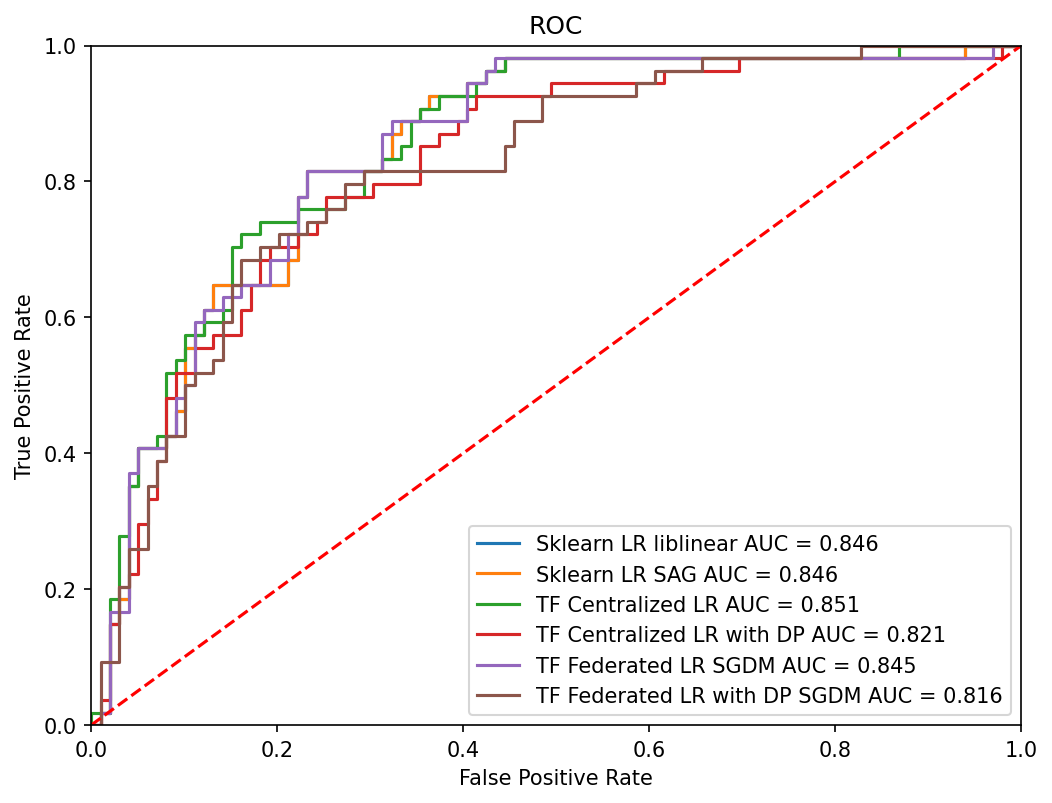

In [57]:
figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
plt.title('ROC')
plt.plot(fpr_skl_liblinear, tpr_skl_liblinear, label = 'Sklearn LR liblinear AUC = %0.3f' % roc_auc_skl_liblinear)
plt.plot(fpr_skl_sag, tpr_skl_sag, label = 'Sklearn LR SAG AUC = %0.3f' % roc_auc_skl_sag)
plt.plot(fpr_tf, tpr_tf, label = 'TF Centralized LR AUC = %0.3f' % roc_auc_tf)
plt.plot(fpr_tf_dp, tpr_tf_dp, label = 'TF Centralized LR with DP AUC = %0.3f' % roc_auc_tf_dp)
plt.plot(fpr_tff_sgd, tpr_tff_sgd, label = 'TF Federated LR SGDM AUC = %0.3f' % roc_auc_tff_sgd)
plt.plot(fpr_tff_dp_sgd, tpr_tff_dp_sgd, label = 'TF Federated LR with DP SGDM AUC = %0.3f' % roc_auc_tff_dp_sgd)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

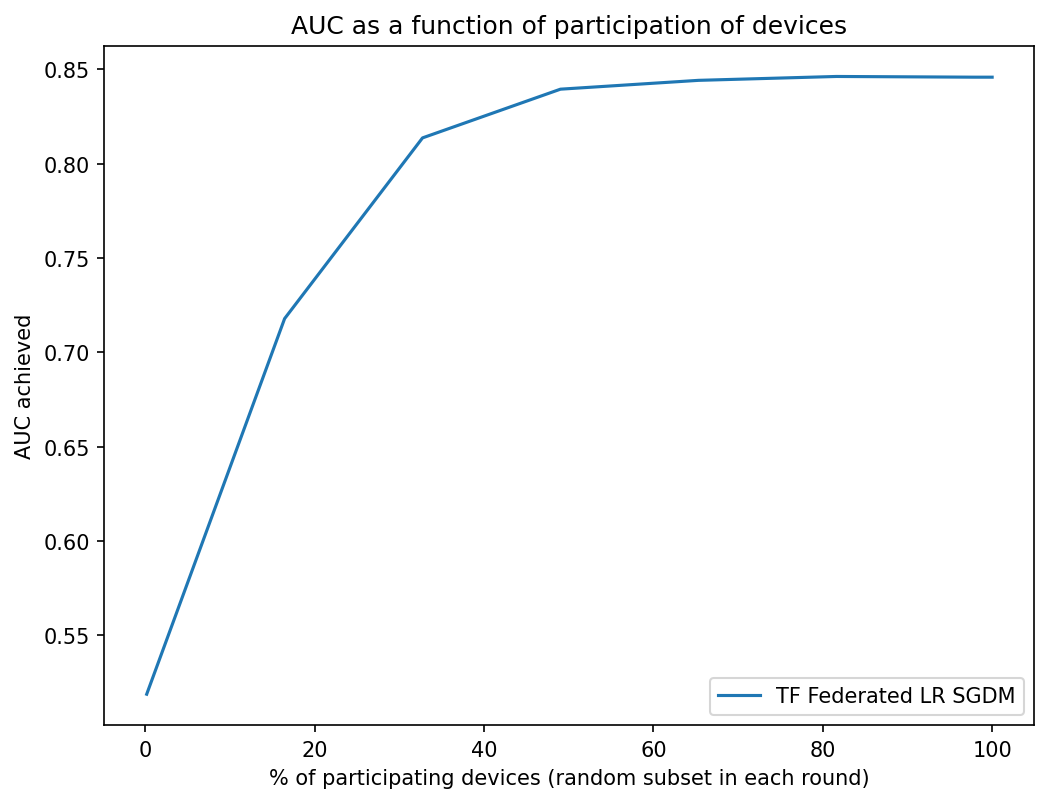

In [58]:
figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
plt.title('AUC as a function of participation of devices')
s = sorted(tff_auc.items(), key = lambda kv:(kv[0], kv[1]))
x_data = [o[0] for o in s]
y_data = [o[1] for o in s]
plt.plot(x_data, y_data, label = 'TF Federated LR SGDM')
plt.legend(loc = 'lower right')
plt.ylabel('AUC achieved')
plt.xlabel('% of participating devices (random subset in each round)')
plt.show()

In [59]:
output_sklearn = sk_model.coef_[0]
output_sklearn = np.insert(output_sklearn, 0, sk_model.intercept_)

output_tf = tf_model.get_weights()[0]
output_tf = np.insert(output_tf, 0, tf_model.get_weights()[1])

output_tff = tff_model.get_weights()[0]
output_tff = np.insert(output_tff, 0, tff_model.get_weights()[1])

print(output_sklearn)
print(output_tf)
print(output_tff)

[-0.88307705  0.40760513  1.03086484 -0.19801368 -0.04664077 -0.08482345
  0.79606028  0.34566597  0.11227563]
[-0.8819431   0.31816941  1.0013016  -0.15618567 -0.00287318 -0.11046062
  0.49678922  0.37429476  0.08513162]
[-0.83001316  0.2949795   0.89249974 -0.13851959 -0.05281442 -0.05092372
  0.68741375  0.29739767  0.16265914]


In [61]:
import time
from sklearn import datasets

def create_keras_model_benchmark(input_dim):
  return tf.keras.models.Sequential([
      tf.keras.layers.Dense(
          1,
          activation='sigmoid',
          input_shape=(input_dim,),
          kernel_regularizer=tf.keras.regularizers.l2(0.01),
      )
  ])

def model_builder(input_dim, input_spec):
  keras_model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(
          1,
          activation='sigmoid',
          input_shape=(input_dim,),
          kernel_regularizer=tf.keras.regularizers.l2(0.01),
      )
  ])
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=input_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
               tf.keras.metrics.AUC(name='auc')])


# Synthetic dataset
MAX_NUM_EXAMPLES = 500
INCREMENT_EXAMPLES = 100
MAX_NUM_FEATURES = 200
INCREMENT_FEATURES = 50

eval_data = np.zeros((round(MAX_NUM_EXAMPLES/INCREMENT_EXAMPLES), round(MAX_NUM_FEATURES/INCREMENT_FEATURES))) 

for e, examples_size in enumerate(list(range(INCREMENT_EXAMPLES, MAX_NUM_EXAMPLES+1, INCREMENT_EXAMPLES))):
  for f, features_size in enumerate(list(range(INCREMENT_FEATURES, MAX_NUM_FEATURES+1, INCREMENT_FEATURES))):
    dataset, labels = sklearn.datasets.make_classification(n_samples=examples_size, n_features=features_size, n_classes=2, weights=[0.75])
    n_train = round(TRAIN_PROPORTION * np.size(dataset, 0))
    data_train = dataset[:n_train]
    labels_train =  labels[:n_train]
    data_test = dataset[n_train:]
    labels_test =  labels[n_train:]

    client_dataset_train = create_client_dataset(data_train, labels_train)
    client_dataset_test = create_client_dataset(data_test, labels_test)
    preprocessed_example_dataset_bench = preprocess(client_dataset_train.create_tf_dataset_for_client(client_dataset_train.client_ids[0]))

    # Create TFF interative process.
    iterative_process = tff.learning.build_federated_averaging_process(
        model_fn=lambda: model_builder(input_dim=features_size, input_spec=preprocessed_example_dataset_bench.element_spec),
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.5),
        use_experimental_simulation_loop = True
    )

    state = iterative_process.initialize()
    tff_model_bench = create_keras_model_benchmark(features_size)
    federated_train_data = make_federated_data(client_dataset_train, range(n_train))

    start_t = time.process_time()
    state, metrics = iterative_process.next(state, federated_train_data)
    elapsed_time = time.process_time() - start_t
    eval_data[e][f] = elapsed_time

    print(examples_size, features_size, elapsed_time, str(metrics))
    state.model.assign_weights_to(tff_model_bench)
    labels_proba = tff_model_bench.predict(data_test)
    fpr, tpr, threshold = sklearn.metrics.roc_curve(labels_test, labels_proba)
    test_loss = tf.keras.losses.binary_crossentropy(labels_test, np.reshape(labels_proba, [-1]))
    print('validation auc={}, loss={}'.format(sklearn.metrics.auc(fpr, tpr), test_loss))

100 50 6.405253930000072 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.575), ('auc', 0.57125), ('loss', 0.78866315), ('num_examples', 80), ('num_batches', 80)]))])
1/1 [==============================] - 0s 90ms/step
validation auc=0.7362637362637362, loss=0.5549259781837463
100 100 5.662736999000117 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.4625), ('auc', 0.42390287), ('loss', 0.99667484), ('num_examples', 80), ('num_batches', 80)]))])
1/1 [==============================] - 0s 64ms/step
validation auc=0.7916666666666667, loss=0.5323477387428284
100 150 5.164659764000135 OrderedDict([('broadcast', ()), ('aggregation', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('train', OrderedDict([('accuracy', 0.425), ('auc', 0.45071685), ('loss', 0.95080376), ('num_examples', 80), ('num_batch

([<matplotlib.axis.XTick at 0x7f38d2764f70>,
 [Text(0, 0, '50'), Text(0, 0, '100'), Text(0, 0, '150'), Text(0, 0, '200')])

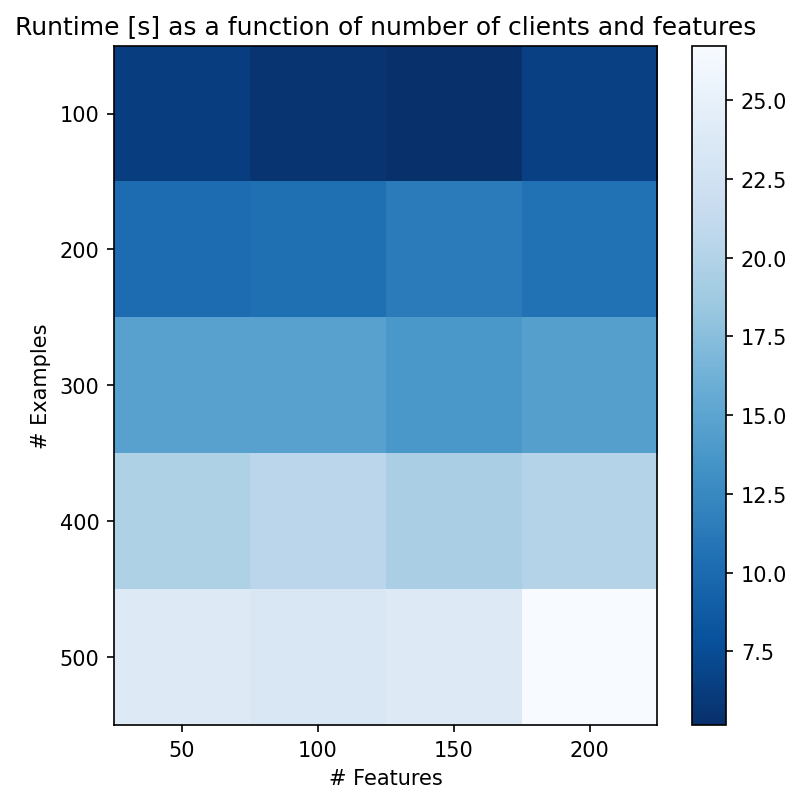

In [62]:
import matplotlib.pyplot as plt
x_axis = list(range(INCREMENT_FEATURES, MAX_NUM_FEATURES+1, INCREMENT_FEATURES))
y_axis = list(range(INCREMENT_EXAMPLES, MAX_NUM_EXAMPLES+1, INCREMENT_EXAMPLES))
plt.figure(figsize=(6, 6), dpi=150)
plt.title('Runtime [s] as a function of number of clients and features')
color_map = plt.imshow(eval_data)
color_map.set_cmap("Blues_r")
plt.colorbar()
plt.ylabel('# Examples')
plt.xlabel('# Features')
plt.yticks(ticks=range(len(y_axis)), labels=y_axis)
plt.xticks(ticks=range(len(x_axis)), labels=x_axis)

In [68]:
import time
from sklearn import datasets


def create_keras_model_benchmark(input_dim):
  return tf.keras.models.Sequential([
      tf.keras.layers.Dense(
          1,
          activation='sigmoid',
          input_shape=(input_dim,),
          kernel_regularizer=tf.keras.regularizers.l2(0.01),
      )
  ])

def model_builder(input_dim, input_spec):
  keras_model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(
          1,
          activation='sigmoid',
          input_shape=(input_dim,),
          kernel_regularizer=tf.keras.regularizers.l2(0.01),
      )
  ])
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=input_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
               tf.keras.metrics.AUC(name='auc')])


# Synthetic dataset
MAX_NUM_EXAMPLES = 5000
INCREMENT_EXAMPLES = 1000
MAX_NUM_FEATURES = 60
INCREMENT_FEATURES = 60

eval_data = np.zeros((round(MAX_NUM_EXAMPLES/INCREMENT_EXAMPLES), round(MAX_NUM_FEATURES/INCREMENT_FEATURES))) 

for e, examples_size in enumerate(list(range(INCREMENT_EXAMPLES, MAX_NUM_EXAMPLES+1, INCREMENT_EXAMPLES))):
  for f, features_size in enumerate(list(range(INCREMENT_FEATURES, MAX_NUM_FEATURES+1, INCREMENT_FEATURES))):
    dataset, labels = sklearn.datasets.make_classification(n_samples=examples_size, n_features=features_size, n_classes=2, weights=[0.75])
    n_train = round(TRAIN_PROPORTION * np.size(dataset, 0))
    data_train = dataset[:n_train]
    labels_train =  labels[:n_train]
    data_test = dataset[n_train:]
    labels_test =  labels[n_train:]

    client_dataset_train = create_client_dataset(data_train, labels_train)
    client_dataset_test = create_client_dataset(data_test, labels_test)
    preprocessed_example_dataset_bench = preprocess(client_dataset_train.create_tf_dataset_for_client(client_dataset_train.client_ids[0]))

    # Create TFF interative process.
    iterative_process = tff.learning.build_federated_averaging_process(
        model_fn=lambda: model_builder(input_dim=features_size, input_spec=preprocessed_example_dataset_bench.element_spec),
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.5),
        use_experimental_simulation_loop = True
    )

    state = iterative_process.initialize()
    tff_model_bench = create_keras_model_benchmark(features_size)
    federated_train_data = make_federated_data(client_dataset_train, range(n_train))

    start_t = time.process_time()
    state, metrics = iterative_process.next(state, federated_train_data)
    elapsed_time = time.process_time() - start_t
    eval_data[e][f] = elapsed_time
    print(examples_size, features_size, elapsed_time)

1000 60 55.6229218389999
2000 60 107.84491163799976
3000 60 166.4823757060003
4000 60 220.65426140599993
5000 60 285.77272564800114


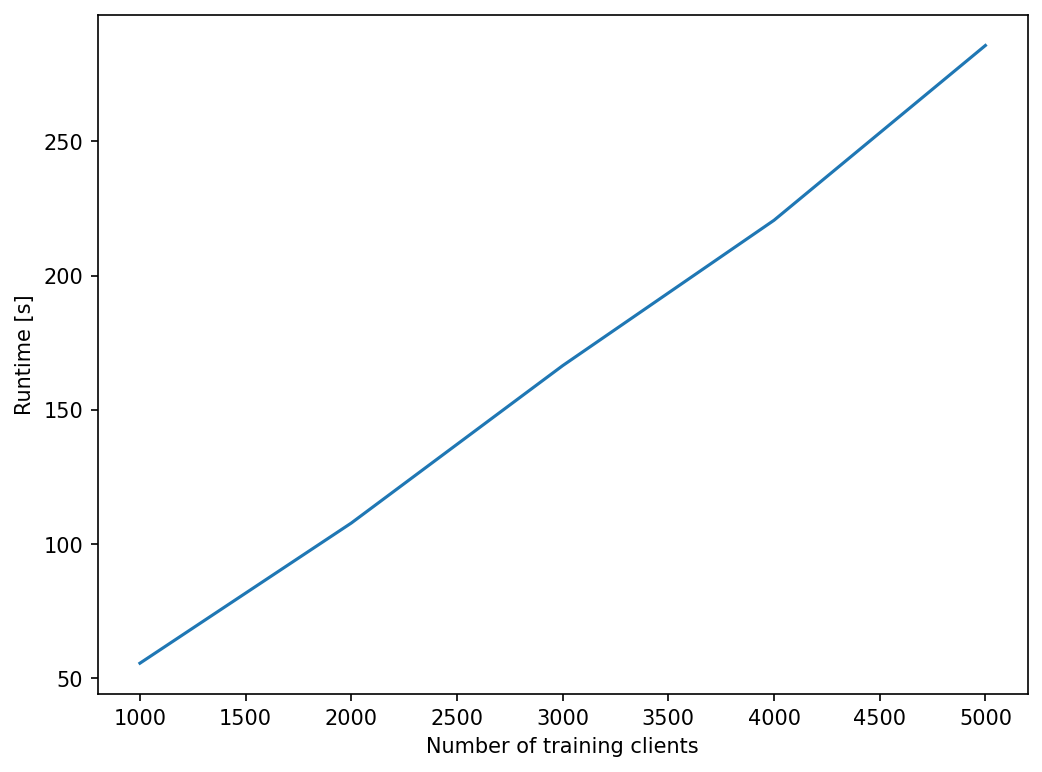

In [69]:
figure(num=None, figsize=(8, 6), dpi=150, facecolor='w', edgecolor='k')
x_axis = list(range(INCREMENT_EXAMPLES, MAX_NUM_EXAMPLES+1, INCREMENT_EXAMPLES))
plt.plot(x_axis, eval_data)
plt.ylabel('Runtime [s]')
plt.xlabel('Number of training clients')
plt.show()